In [1]:
import numpy as np
import torch
from torchvision import models, datasets, transforms
import torchvision
from tqdm import tqdm
from scipy.stats import ttest_ind
from scipy.stats import bootstrap

In [2]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, TensorDataset
# import torchattacks
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

In [3]:
from utils import *
#from imagenet_class import imagenet_label
import os
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]='1'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Batch_size = 1
print(device)

cuda


In [4]:
transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0, 0, 0], std=[1/255., 1/255., 1/255.])
        ]
    )
dataset = torchvision.datasets.ImageNet(root="~/project/data", split='train',
                             transform=transform
                                       )
Scale2One = transforms.Normalize(mean=[0, 0, 0], std=[255., 255., 255.])
test_loader = torch.utils.data.DataLoader(dataset, batch_size=Batch_size, shuffle=True)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [5]:
def pad_shape(Num, size=8):
    res = Num%size
    pad = 1
    if(res == 0):
        pad = 0
    n = (Num//size+pad)*size
    return n

def blockify(im: torch.Tensor, size: int) -> torch.Tensor:
    shape = im.shape[-2:]
    padded_shape = [pad_shape(shape[0]),pad_shape(shape[1])]
    paded_im = F.pad(im, (0,padded_shape[1]-shape[1], 0,padded_shape[0]-shape[0]), 'constant',0)
    bs = paded_im.shape[0]
    ch = paded_im.shape[1]
    h = paded_im.shape[2]
    w = paded_im.shape[3]
    paded_im = paded_im.reshape(bs * ch, 1, h, w)
    paded_im = torch.nn.functional.unfold(paded_im, kernel_size=(size, size), stride=(size, size))
    paded_im = paded_im.transpose(1, 2)
    paded_im = paded_im.reshape(bs, ch, -1, size, size)
    return paded_im

def deblockify(blocks: torch.Tensor, size) -> torch.Tensor:
    padded_shape = pad_shape(size[0]),pad_shape(size[1])
    bs = blocks.shape[0]
    ch = blocks.shape[1]
    block_size = blocks.shape[3]
    blocks = blocks.reshape(bs * ch, -1, int(block_size ** 2))
    blocks = blocks.transpose(1, 2)
    blocks = torch.nn.functional.fold(blocks, output_size=padded_shape, kernel_size=(block_size, block_size), stride=(block_size, block_size))
    blocks = blocks.reshape(bs, ch, padded_shape[0], padded_shape[1])
    blocks = blocks[:,:,:size[0],:size[1]]
    return blocks

In [39]:
data, target = next(iter(test_loader))

torch.Size([375, 500])

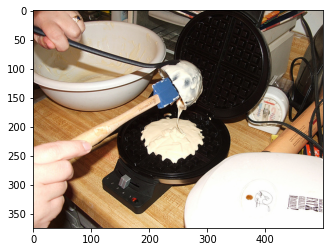

In [40]:
plt.imshow((data.cpu().numpy()[0]).transpose(1,2,0)/255)
shape = data.shape[-2:]
shape

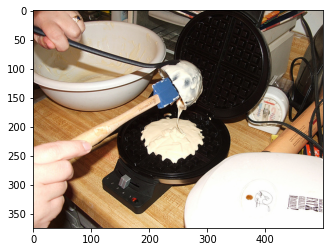

In [41]:
rcvimg = deblockify(blockify(data, 8), shape)
plt.imshow((rcvimg.cpu().numpy()[0]).transpose(1,2,0)/255)

In [42]:
torch.sum(torch.abs(rcvimg-data))

tensor(0.)